In [1]:
using StarStats

In [2]:
function path_constructor(strings::Vector{String})
    DATA_FOLDER = ENV["STARSTATS_TEST_DATA_FOLDER"]
    return DATA_FOLDER*"/LMC/LMC_0.00_$(strings[1])_1.00.track.gz"
end

path_constructor (generic function with 1 method)

In [3]:
using Printf
using BenchmarkTools
masses = [@sprintf("%.3f", x) for x in range(0.9,2.1,step=0.025)]

grid = ModelDataGrid([masses],[:logM])
load_grid(grid,path_constructor); 
compute_distances_and_EEPs(grid)

In [4]:
using Plots
plot()
for df in grid.dfs
    plot!(df.Teff, df.logL)
end
plot!()
xflip!()

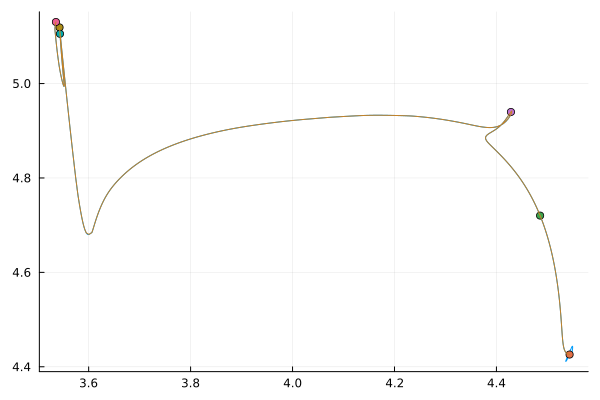

In [6]:
plot(legend=false)
plot!(grid.dfs[14].Teff, grid.dfs[14].logL)
EEPs = grid.EEPs[14,:]
for i in EEPs
    scatter!([grid.dfs[14].Teff[i]], [grid.dfs[14].logL[i]])
end

track = grid.dfs[14]
xvals = LinRange(0,5,1000)
log_Teff = get_secondary_EEP.(xvals,Ref(track),Ref(EEPs),Ref(:Teff))
log_L = get_secondary_EEP.(xvals,Ref(track),Ref(EEPs),Ref(:logL))

plot!(log_Teff, log_L)

In [8]:
function path_constructor(strings::Vector{String})
    DATA_FOLDER = ENV["STARSTATS_TEST_DATA_FOLDER"]
    return DATA_FOLDER*"/LMC/LMC_$(strings[1])_$(strings[2])_$(strings[3]).track.gz"
end

path_constructor (generic function with 1 method)

In [9]:
using Printf
using BenchmarkTools
masses = [@sprintf("%.3f", x) for x in range(0.9,2.1,step=0.025)]
rotation = [@sprintf("%.2f", x) for x in range(0.0,0.9,step=0.1)]
overshoot = [@sprintf("%.2f", x) for x in range(0.5,4.5,step=0.5)]
grid = ModelDataGrid([rotation,masses,overshoot],
    [:rotation,:logM,:overshoot])
#@benchmark 
load_grid(grid,path_constructor); 
compute_distances_and_EEPs(grid)

In [14]:
observable_names = [:Teff, :logL, :vrot]
observable_values = [4.51974, 4.289877, 70.7195]
observable_errors = [0.2, 0.2, 10]
# potentially parallelize this
grid_likelihood = ModelDataGridLikelihood(grid, observable_names, observable_values, observable_errors);

In [15]:
CI = credible_interval(grid_likelihood, :logM,0.68,1_000_000)

([1.193889893889894, 1.125000225000225, 1.0427065427065427], 8325.806601611876)

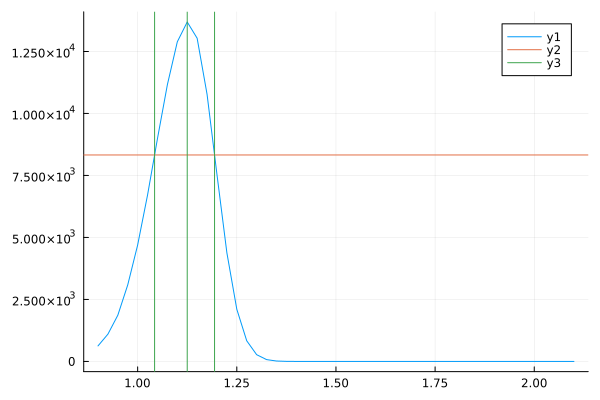

In [16]:
using Plots
ml= marginalized_likelihood(grid_likelihood,[:logM])
plot(grid.input_values[2], ml)
hline!([CI[2]])
vline!(CI[1])

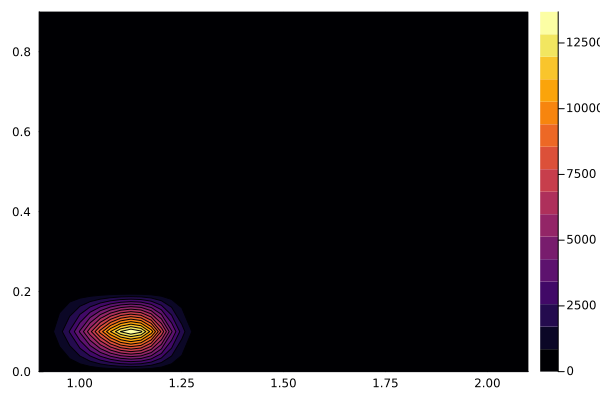

In [17]:
using Plots

ml= marginalized_likelihood(grid_likelihood,[:logM, :rotation])
contour(grid.input_values[2], grid.input_values[1], ml', fill=true)

In [18]:
#for next time 
# track interpolation
# Add comments to package source code

# Turn MESA history into EEP
#   
# Interpolate EEP for single stars
# Incorporate interpolated data into likelihood computation
# Model comparisons

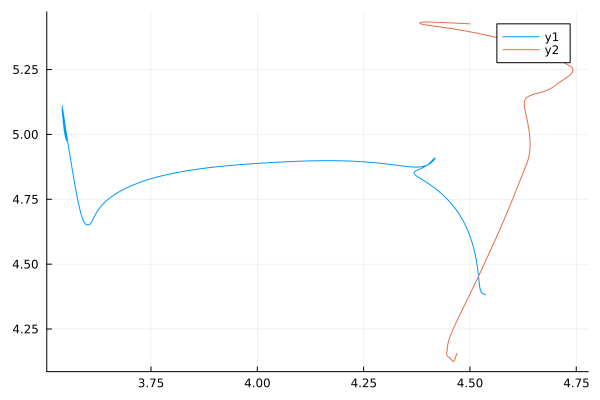

In [19]:
using Plots
plot()
xvals = LinRange(0,5, 1000)
plot!(interpolate_grid_quantity.(Ref(grid),Ref([0.13,1.21,1.05]),:Teff, xvals), interpolate_grid_quantity.(Ref(grid),Ref([0.13,1.21,1.05]),:logL, xvals))
plot!(interpolate_grid_quantity.(Ref(grid),Ref([0.89,1.21,3]),:Teff, xvals), interpolate_grid_quantity.(Ref(grid),Ref([0.89,1.21,3]),:logL, xvals))

In [47]:
using Turing, Distributions
@model function star_model(logTeff_obs, logTeff_err, logL_obs, logL_err, vrot_obs, vrot_err, grid)
    x ~ Uniform(0,3)
    logM ~ Uniform(0.9, 1.5)
    rotation ~ Uniform(0,0.9)
    overshoot ~ Uniform(0.5,1.5)
    logTeff = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:Teff,x)
    logL = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:logL,x)
    vrot = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:vrot,x)

    logTeff_obs ~ Normal(logTeff, logTeff_err)
    logL_obs ~ Normal(logL, logL_err)
    vrot_obs ~ Normal(vrot, vrot_err)
    return logTeff_obs, logL_obs, vrot_obs
end

star_model (generic function with 4 methods)

In [56]:
chain = sample(star_model(4.51974, 0.2, 4.289877, 0.2, 70.7195, 20, grid), NUTS(10_000,0.6), 200; progress=true);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /lhome/pablom/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /lhome/pablom/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /lhome/pablom/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /lhome/pablom/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /lhome/pablom/.julia/packages/AdvancedHMC/iWHPQ/src

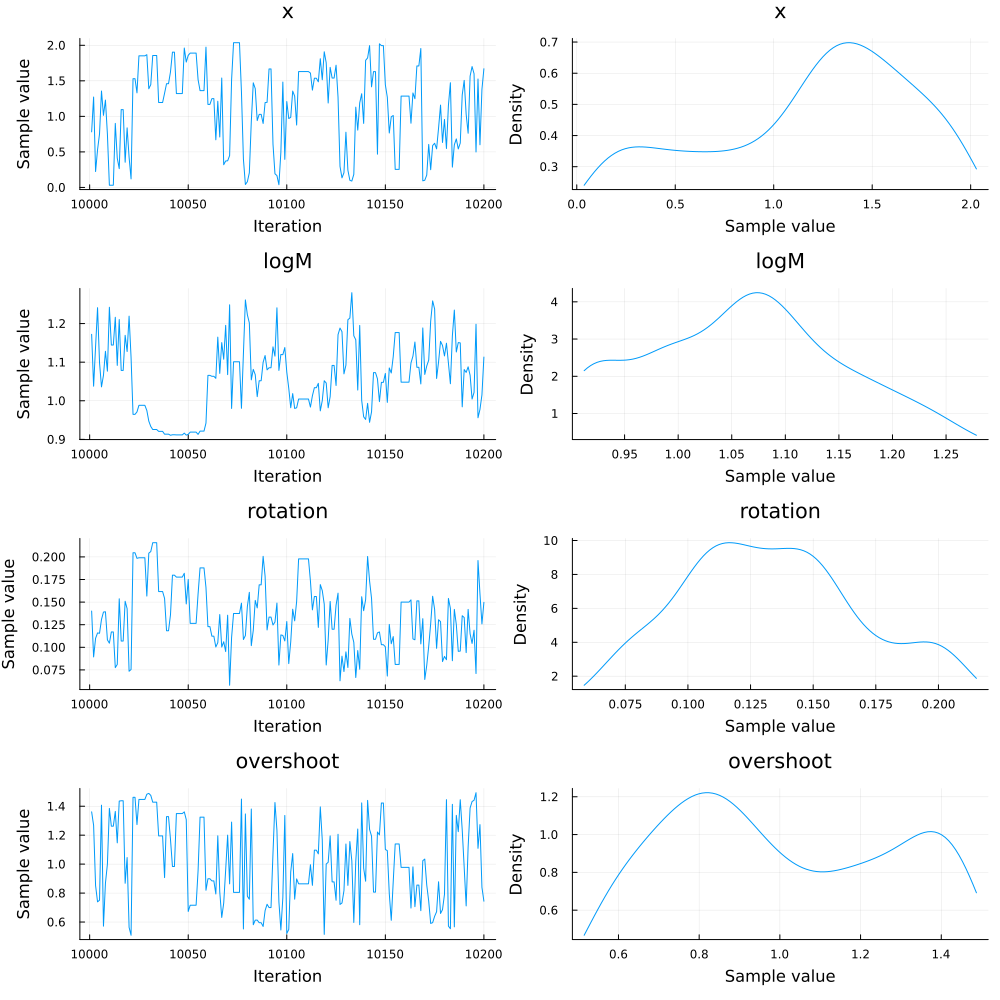

In [57]:
using StatsPlots
plot(chain)

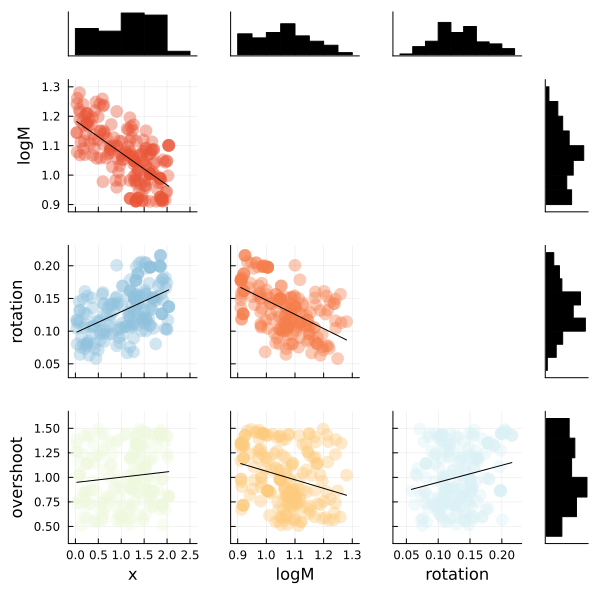

In [58]:
corner(chain)